# MolMap with generator (dual-path approach)

### Load data

In [2]:
'Set the file name of your data'
data_name = "CYP450.csv.gz"

In [3]:
import numpy as np
import pandas as pd

data = pd.read_csv("../../../data/" + data_name, compression='gzip')

Set up (adapt according to your data)

In [4]:
# keep desired columns
data = data[['smiles', 'label_2c9']]

# drop molecules with NaN activity
data = data.dropna(subset = ["label_2c9"])

# set SMILES
smi = data['smiles'].tolist()

# set Y
Y = pd.get_dummies(data['label_2c9']).values

# number of active and inactive molecules
print("Inactive (0):", Y[:,1].tolist().count(0))
print("Active (1):", Y[:,1].tolist().count(1))

Inactive (0): 7429
Active (1): 2621


### Do MolMap: from MolDs & FFs to Fmaps

In [5]:
import pickle
from molmap import MolMap
from molmap import feature
from ondiskxy import MatrixWriter
from ondiskxy.utils import chunker
import os
from os import path

dir_path_X1 = "../../../files/" + data_name + "/molmap/X1/X1"
dir_path_X2 = "../../../files/" + data_name + "/molmap/X2/X2"

if not path.isdir(dir_path_X1) or not path.isdir(dir_path_X2):
    'If it doesn´t exist, we compute it and save it to disk.'
    # compute MolDs
    mp1 = MolMap(ftype='descriptor', metric='cosine',)
    mp1.fit(verbose=0, method='umap', min_dist=0.1, n_neighbors=15)
    
    # compute FFs
    bitsinfo = feature.fingerprint.Extraction().bitsinfo
    flist = bitsinfo[bitsinfo.Subtypes.isin(['PubChemFP', 'MACCSFP', 'PharmacoErGFP'])].IDs.tolist()
    mp2 = MolMap(ftype = 'fingerprint', fmap_type = 'scatter', flist = flist) 
    mp2.fit(method = 'umap',  min_dist = 0.1, n_neighbors = 15, verbose = 0)

    # get Fmaps and save them in chunks to disk 
    writer = MatrixWriter(dir_path=dir_path_X1, max_file_size_mb=1000)
    for smiles_chunk in chunker(smi, 10000):
        X1 = mp1.batch_transform(smiles_chunk)
        writer.append(X1)
        
    writer = MatrixWriter(dir_path=dir_path_X2, max_file_size_mb=1000)
    for smiles_chunk in chunker(smi, 10000):
        X2 = mp2.batch_transform(smiles_chunk)
        writer.append(X2)

### Get indices for train, validation and test sets

In [6]:
import sys
sys.path.append("../../../src")
from utils import Rdsplit

train_idx, valid_idx, test_idx = Rdsplit(data, random_state = 888)

8040 1005 1005


### Get train, validation and test sets

**Get X (train, val and test)**

First, if we don't have our X1 and X2 matrices saved in one single file in disk, we do an assembler. 

In [7]:
# assembler
from ondiskxy.hdf5 import Hdf5Assembler

path_X1 = "../../../files/" + data_name + "/molmap/X1/X1.h5"
path_X2 = "../../../files/" + data_name + "/molmap/X2/X2.h5"

if not path.isfile(path_X1) or not path.isfile(path_X2):
    'If it doesn´t exist, we compute it and save it to disk.'
    # assembler X1
    assembler = Hdf5Assembler(dir_path_X1)
    assembler.assemble(path_X1)
    
    # assembler X2
    assembler = Hdf5Assembler(dir_path_X2)
    assembler.assemble(path_X2)

Then, we access to this matrices X1 and X2 and we keep only the needed indexes for computing our train, val and test files.

In [8]:
# filter_by_index 
from ondiskxy import filter_by_index

path_trainX1 = "../../../files/" + data_name + "/molmap/X1/trainX1.h5"
path_trainX2 = "../../../files/" + data_name + "/molmap/X2/trainX2.h5"
path_validX1 = "../../../files/" + data_name + "/molmap/X1/validX1.h5"
path_validX2 = "../../../files/" + data_name + "/molmap/X2/validX2.h5"
path_testX1 = "../../../files/" + data_name + "/molmap/X1/testX1.h5"
path_testX2 = "../../../files/" + data_name + "/molmap/X2/testX2.h5"

if not path.isfile(path_trainX1):
    'If it doesn´t exist, we compute it and save it to disk.' 
    filter_by_index(train_idx, path_X1, path_trainX1)
    filter_by_index(train_idx, path_X2, path_trainX2)
    filter_by_index(valid_idx, path_X1, path_validX1)
    filter_by_index(valid_idx, path_X2, path_validX2)
    filter_by_index(test_idx, path_X1, path_testX1)
    filter_by_index(test_idx, path_X2, path_testX2)

**Get Y (train, val and test)**

(obtained directly)

In [9]:
trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

### Get dimensions

In [10]:
import h5py

with h5py.File(path_validX1, "r") as f:
    validX1 = np.array(f["data"])
    
with h5py.File(path_validX2, "r") as f:
    validX2 = np.array(f["data"])

In [11]:
shapeX1 = validX1.shape[1:]
dimX1 = shapeX1[:-1]
nchannelsX1 = shapeX1[-1]

shapeX2 = validX2.shape[1:]
dimX2 = shapeX2[:-1]
nchannelsX2 = shapeX2[-1]

nclasses = validY.shape[1]

print("shape X1:", shapeX1)
print("dim X1:", dimX1)
print("n channels X1:", nchannelsX1)
print("shape X2:", shapeX2)
print("dim X2:", dimX2)
print("n channels X2:", nchannelsX2)
print("n classes:", nclasses)

shape X1: (37, 37, 13)
dim X1: (37, 37)
n channels X1: 13
shape X2: (72, 72, 3)
dim X2: (72, 72)
n channels X2: 3
n classes: 2


### Get generators for train, validation and test

In [12]:
from generator import Hdf5Generator

XY_train_generator = Hdf5Generator(path_trainX1, dimX1, nchannelsX1, path_trainX2, dimX2, nchannelsX2, trainY[:,1], nclasses, batch_size=64, sample_weight=True, shuffle=True)
XY_valid_generator = Hdf5Generator(path_validX1, dimX1, nchannelsX1, path_validX2, dimX2, nchannelsX2, validY[:,1], nclasses, batch_size=64, shuffle=True)
XY_test_generator = Hdf5Generator(path_testX1, dimX1, nchannelsX1, path_testX2, dimX2, nchannelsX2, testY[:,1], nclasses, batch_size=64)

### Build model (MultiClassEstimator)

In [13]:
sys.path.append("../../../tools/bidd-molmap/molmap/model")
from model import MultiClassEstimator_largedata

clf = MultiClassEstimator_largedata(n_outputs=trainY.shape[1], 
                          fmap_shape1 = shapeX1,
                          fmap_shape2 = shapeX2,
                          metric='ROC', 
                          dense_layers = [128, 64],  gpuid = 0, epochs = 100,
                          callbacks_path = "../../../files/" + data_name + "/molmap/checkpoints.h5")

MultiClassEstimator_largedata(callbacks_path='../../../files/CYP450.csv.gz/molmap/checkpoints.h5',
                              epochs=100, fmap_shape1=(37, 37, 13),
                              fmap_shape2=(72, 72, 3), gpuid='0', n_outputs=2)


### Train model

In [14]:
from molmap.model import save_model, load_model

dir_path_model = "../../../files/" + data_name + "/molmap/model"
path_history = "../../../files/" + data_name + "/molmap/history.pkl"

if path.isdir(dir_path_model):
    with open(path_history, 'rb') as f:
        history_dict = pickle.load(f)
    clf = load_model(dir_path_model)

else: 
    history_clf = clf.fit(XY_train_generator, XY_valid_generator) 
    save_model(clf, dir_path_model)
    history_dict = history_clf.history
    with open(path_history, 'wb') as f:
        pickle.dump(history_dict, f)

### Plot training history

<AxesSubplot:title={'center':'Performance Learning Curve'}>

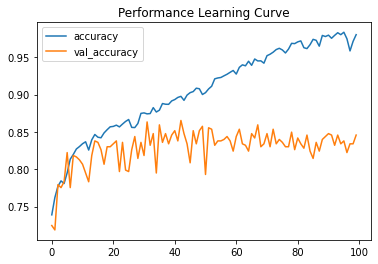

In [15]:
pd.DataFrame(history_dict)[['accuracy', 'val_accuracy']].plot(title="Performance Learning Curve")

<AxesSubplot:title={'center':'Optimization Learning Curve'}>

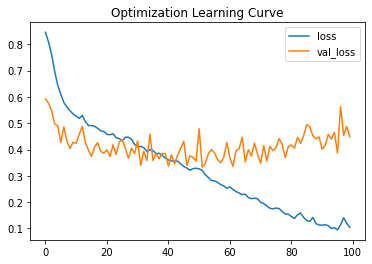

In [16]:
pd.DataFrame(history_dict)[['loss', 'val_loss']].plot(title="Optimization Learning Curve")

### Evaluation on test set: AUC

In [17]:
score = clf.score(XY_test_generator)
print("Test AUC:", round(score[1], 3))

Test AUC: 0.835
